In [18]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [3]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [54]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\BIOS\nurses_extracted.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_21432\2285215604.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,hard_text,profession,gender,skills_extracted,education_extracted,countries_extracted,experience_years
0,mr. orallo received his advanced nurse practit...,nurse,male,[],['nurse practitioner'],[],NaN
1,he graduated with honors in 2012. having more ...,nurse,male,[],[],['nurse'],6.0
2,he graduated with honors in 2012. having more ...,nurse,male,[],[],['nurse'],4.0
3,he describes a typical day in the private pain...,nurse,male,[],[],['neuralgia'],NaN
4,edwin auman (as his nurse) for twenty-one year...,nurse,male,[],[],[],NaN
...,...,...,...,...,...,...,...
195,"growing up in budapest, sacramento, and colley...",nurse,female,[],[],"['budapest', 'sacramento']",NaN
196,she is currently working at the huntsman cance...,nurse,female,[],[],[],NaN
197,she graduated with honors in 2012. having more...,nurse,female,[],[],['nurse'],5.0
198,she graduated with honors in 2012. having more...,nurse,female,[],[],"['thedacare', 'nurse']",4.0


In [ ]:

# Use only the 'hard_text' column for text input
texts = df["hard_text"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 200
["mr. orallo received his advanced nurse practitioner degree from maryville university. he worked as registered nurse in electrophysiology lab at st. luke's hospital and in icu at centerpoint medical center.", 'he graduated with honors in 2012. having more than 6 years of diverse experiences, especially in nurse practitioner, jared kasey jones affiliates with many hospitals including gadsden regional medical center, grandview medical center, dekalb regional medical center, and cooperates with other doctors and specialists without joining any medical groups. call jared kasey jones on phone number (256) 543-3508 for more information and advice or to book an appointment.', 'he graduated with honors in 2012. having more than 4 years of diverse experiences, especially in nurse practitioner, michael christensen affiliates with many hospitals including ogden regional medical center, brigham city community hospital, lakeview hospital, and cooperates with other doctor

In [34]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


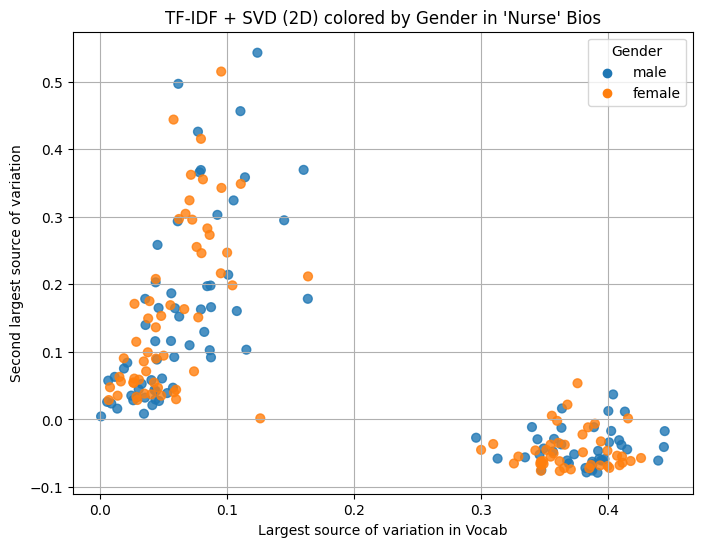

In [75]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in 'Nurse' Bios")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [83]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [84]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [86]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [87]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,medical,0.304316,-0.024171,male
1,hospital,0.207660,-0.027221,male
2,appointment,0.182264,0.060103,female
3,cooperates,0.182022,0.045869,female
4,affiliates,0.182022,0.045869,female
5,doctors,0.181561,0.060947,female
6,honors,0.181283,0.053315,female
7,having,0.180697,0.048277,female
8,specialists,0.180487,0.047277,female
9,information,0.180414,0.041078,female



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,nursing,0.447604,0.005277,female
1,university,0.316718,-0.038128,male
2,science,0.260522,0.004612,female
3,degree,0.198397,0.024875,female
4,bachelor,0.182151,0.030564,female
5,care,0.164609,-0.015038,male
6,master,0.163516,-0.036324,male
7,earned,0.138238,0.124917,female
8,received,0.134160,0.009363,female
9,family,0.114273,-0.055536,male


In [ ]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
           word  coefficient predicted_gender
948          dr     0.661726           Female
1638        mrs     0.651580           Female
456         amy     0.454397           Female
955      earned     0.442790           Female
1639         ms     0.416362           Female
1276    husband     0.395477           Female
644      cancer     0.377666           Female
982   elizabeth     0.372368           Female
2462      women     0.368415           Female
2310  tennessee     0.335940           Female
2485       yoga     0.326955           Female
2089    sanford     0.318741           Female
23           11     0.308620           Female
1555      mason     0.307005           Female
1403   kathleen     0.295920           Female
656      caring     0.295349           Female
2270    surgery     0.295228           Female
450       amber     0.286576           Female
1805         pc     0.285130           Female
1379    joining     0.284697           Female


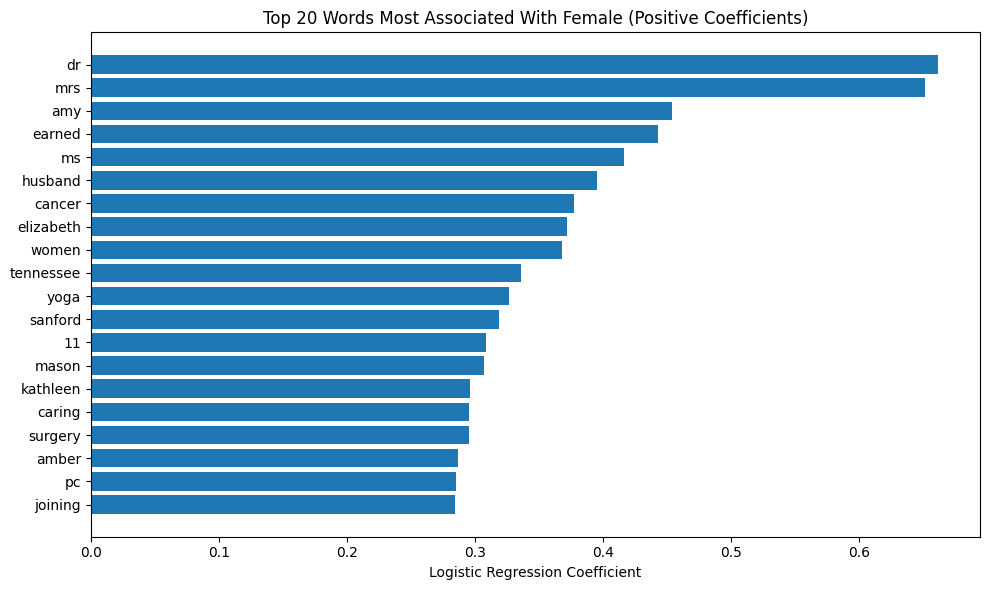

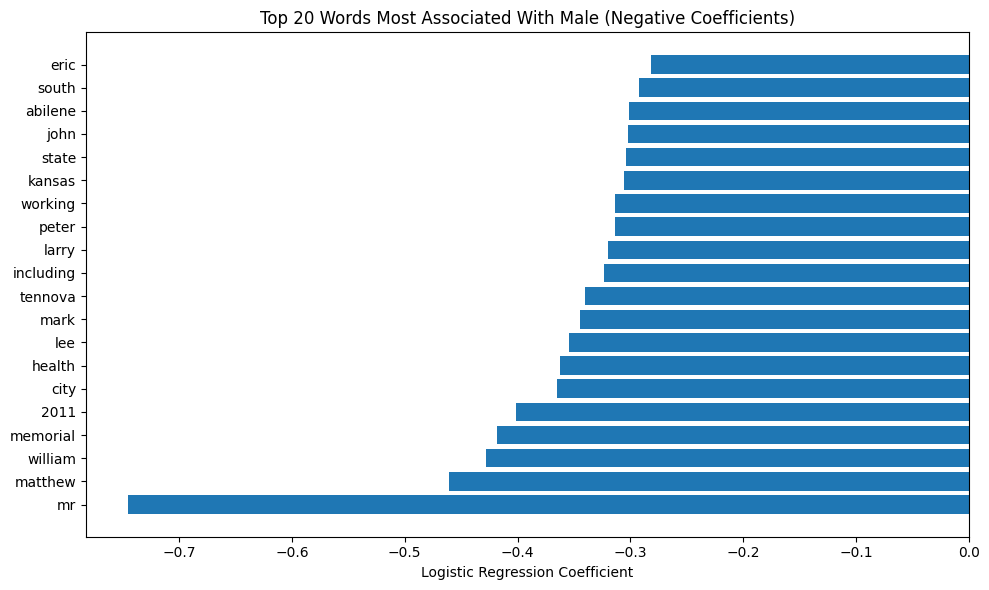

In [88]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()
